In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()
import urllib.request
import cv2
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Loading Train, Augmented Train, Validation and Test dataset

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = (48, 48)
train_dir = "../input/fer2013tatv/dataset/train" 
train_aug_dir = "../input/fer2013tatv/dataset/train_augmented"
val_dir = "../input/fer2013tatv/dataset/validation"
test_dir = "../input/fer2013tatv/dataset/test" 

train_dataset = image_dataset_from_directory(train_dir,shuffle=True, color_mode = 'rgb',batch_size=BATCH_SIZE,image_size=IMAGE_SIZE, seed = 42)
train_aug_dataset = image_dataset_from_directory(train_aug_dir,shuffle=True, color_mode = 'rgb',batch_size=BATCH_SIZE,image_size=IMAGE_SIZE, seed = 42)

validation_dataset = image_dataset_from_directory(val_dir,shuffle=True,color_mode = 'rgb', batch_size=BATCH_SIZE,image_size=IMAGE_SIZE, seed = 42)
test_dataset = image_dataset_from_directory(test_dir,shuffle=True,color_mode = 'rgb', batch_size=3589,image_size=IMAGE_SIZE, seed = 42)



Found 28709 files belonging to 7 classes.


2022-03-22 02:15:19.279708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 02:15:19.375681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 02:15:19.376762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 02:15:19.385212: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 108711 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.


In [4]:
#checking class names
class_names = train_dataset.class_names
class_names

['0', '1', '2', '3', '4', '5', '6']

In [5]:
# dictionary to map the class into human readable labels
class_mapping = {'0': 'Angry', '1': 'Disgust', '2': 'Fear', '3': 'Happy', '4': 'Sad', '5': 'Surprise', '6' : 'Neutral'}

In [6]:
# mapping of class labels
clas = pd.Series(train_dataset.class_names).map(class_mapping)
clas =  list(clas)
clas

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [7]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)
IMAGE_SHAPE

(48, 48, 3)

# Display random Images from Train dataset

2022-03-22 02:15:48.214960: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


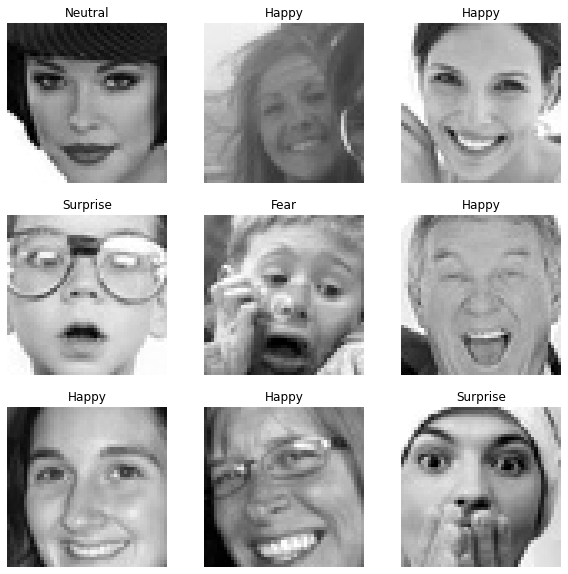

In [8]:
class_label = clas#train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_label[labels[i]])
        plt.axis("off")

# Display random images from Train Augmented dataset

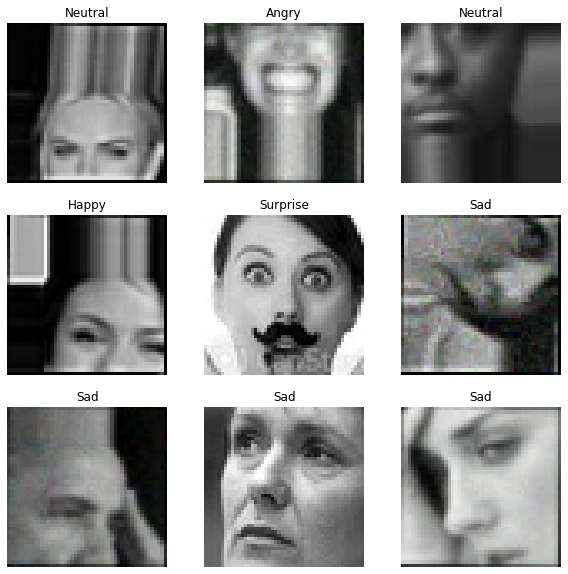

In [9]:
class_label = clas

plt.figure(figsize=(10, 10))
for images, labels in train_aug_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_label[labels[i]])
        plt.axis("off")

In [10]:
# creating cache to load data rapidally
AUTOTUNE = tf.data.AUTOTUNE


train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_aug_dataset = train_aug_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Model Architecture with 7 class output

In [11]:
def MobileNetV2Model():
    MobileNetV2_base_model = tf.keras.applications.MobileNetV2(input_shape = IMAGE_SHAPE, include_top = False, weights = 'imagenet')
    MobileNetV2_base_model.trainable = True
    MobileNetV2 = Sequential()
    MobileNetV2.add(tfl.Rescaling(1./255, input_shape = IMAGE_SHAPE))
    MobileNetV2.add(MobileNetV2_base_model)
    MobileNetV2.add(tfl.Flatten())
    MobileNetV2.add(tfl.Dense(1024, activation = 'relu'))
    MobileNetV2.add(tfl.Dense(512, activation = 'relu'))
    MobileNetV2.add(tfl.Dropout(0.3))
    MobileNetV2.add(tfl.Dense(7, activation = 'softmax'))
    return MobileNetV2

In [12]:
# Model Summary
MobileNetV2_model = MobileNetV2Model()
MobileNetV2_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 48, 48, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              5243904   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
___________________________________________________________

# Plot model defined above

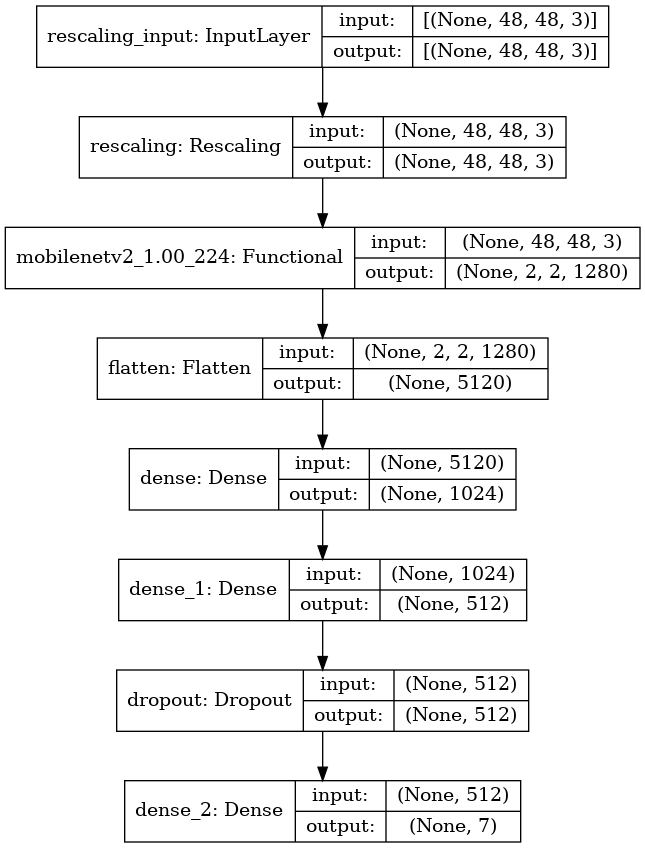

In [13]:
plot_model(MobileNetV2_model, to_file='MobileNetV2_model_plot.png', show_shapes=True, show_layer_names=True)

# Function to Fit the model

In [14]:
def FitModel(model, train_dataset, validation_data, epochs, learning_rate, steps, classWeight = False):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    checkpoint_filepath = 'MobileNetV2_max_val.h5'
    model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True, verbose = 1)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 0, patience = 8, min_delta = 1e-3, restore_best_weights = True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.000001, mode = 'min')
    
    # class weight is assigned to provide weights to each class so that model do not overfit 
    if classWeight:
        class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(class_names), y = class_names)
        weight = {i: class_weights[i] for i in range(7)}
        print('Class Weight:', weight)
        
        model_history = model.fit(train_dataset, validation_data = validation_dataset, verbose = 0,epochs = epochs,steps_per_epoch = steps, callbacks=[tqdm_callback,early_stopping ,reduce_lr,model_callback], shuffle = True, class_weight = weight)
    
    else:
        
        model_history = model.fit(train_dataset, validation_data = validation_dataset, verbose = 0,epochs = epochs,steps_per_epoch = steps, callbacks=[tqdm_callback,early_stopping ,reduce_lr,model_callback], shuffle = True)

    return model_history
        

In [15]:
initial_epochs = 100

MobileNetV2_model_history = FitModel(MobileNetV2_model, train_aug_dataset, validation_dataset, initial_epochs , 0.0001, None, classWeight = True)

Class Weight: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/1699           ETA: ?s - 

2022-03-22 02:16:01.838815: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00001: val_accuracy improved from -inf to 0.41376, saving model to MobileNetV2_max_val.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100


0/1699           ETA: ?s - 


Epoch 00002: val_accuracy improved from 0.41376 to 0.49568, saving model to MobileNetV2_max_val.h5
Epoch 3/100


0/1699           ETA: ?s - 


Epoch 00003: val_accuracy improved from 0.49568 to 0.53079, saving model to MobileNetV2_max_val.h5
Epoch 4/100


0/1699           ETA: ?s - 


Epoch 00004: val_accuracy improved from 0.53079 to 0.56395, saving model to MobileNetV2_max_val.h5
Epoch 5/100


0/1699           ETA: ?s - 


Epoch 00005: val_accuracy improved from 0.56395 to 0.58763, saving model to MobileNetV2_max_val.h5
Epoch 6/100


0/1699           ETA: ?s - 


Epoch 00006: val_accuracy improved from 0.58763 to 0.58874, saving model to MobileNetV2_max_val.h5
Epoch 7/100


0/1699           ETA: ?s - 


Epoch 00007: val_accuracy improved from 0.58874 to 0.59599, saving model to MobileNetV2_max_val.h5
Epoch 8/100


0/1699           ETA: ?s - 


Epoch 00008: val_accuracy improved from 0.59599 to 0.62051, saving model to MobileNetV2_max_val.h5
Epoch 9/100


0/1699           ETA: ?s - 


Epoch 00009: val_accuracy did not improve from 0.62051
Epoch 10/100


0/1699           ETA: ?s - 


Epoch 00010: val_accuracy did not improve from 0.62051
Epoch 11/100


0/1699           ETA: ?s - 


Epoch 00011: val_accuracy did not improve from 0.62051
Epoch 12/100


0/1699           ETA: ?s - 


Epoch 00012: val_accuracy did not improve from 0.62051
Epoch 13/100


0/1699           ETA: ?s - 


Epoch 00013: val_accuracy did not improve from 0.62051
Epoch 14/100


0/1699           ETA: ?s - 


Epoch 00014: val_accuracy did not improve from 0.62051
Epoch 15/100


0/1699           ETA: ?s - 


Epoch 00015: val_accuracy did not improve from 0.62051
Epoch 16/100


0/1699           ETA: ?s - 


Epoch 00016: val_accuracy did not improve from 0.62051


In [16]:
 ls

MobileNetV2_max_val.h5  MobileNetV2_model_plot.png  __notebook__.ipynb


# Plot the DenseNet model - Accuracy, Loss, Validation Accuracy, Validation Loss

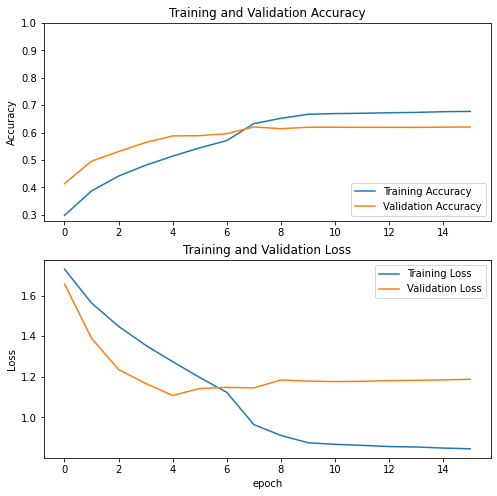

In [17]:


acc = MobileNetV2_model_history.history['accuracy']
val_acc = MobileNetV2_model_history.history['val_accuracy']

loss = MobileNetV2_model_history.history['loss']
val_loss = MobileNetV2_model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate the model on Test dataset

In [18]:
MobileNetV2_model.evaluate(test_dataset)

2022-03-22 02:41:42.094197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2587 of 28712
2022-03-22 02:41:45.867966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1/1 [==============================] - 15s 15s/step - loss: 1.1695 - accuracy: 0.6174


[1.1694520711898804, 0.6174421906471252]

In [19]:
# splitting the test_dataset in feature images and its class
X = []
Y = []
for x, y in test_dataset:
    X.append(x)
    Y.append(y)

In [20]:
# Predicting the images class
pred = MobileNetV2_model.predict(X)
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))

In [21]:
print(classification_report(pred_label,y ,digits=5))

              precision    recall  f1-score   support

           0    0.50107   0.52703   0.51372       444
           1    0.58929   0.64706   0.61682        51
           2    0.45766   0.50000   0.47789       454
           3    0.79553   0.80452   0.80000       885
           4    0.49923   0.49023   0.49469       665
           5    0.78554   0.80494   0.79512       405
           6    0.58979   0.52263   0.55418       685

    accuracy                        0.61744      3589
   macro avg    0.60259   0.61377   0.60749      3589
weighted avg    0.61814   0.61744   0.61720      3589



In [22]:
pd.DataFrame(confusion_matrix(pred_label,y,labels = [0, 1, 2, 3, 4, 5,  6]), columns = class_label)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
0,234,6,44,30,73,9,48
1,9,33,1,3,4,0,1
2,55,5,227,28,66,38,35
3,34,2,18,712,54,13,52
4,73,7,107,34,326,12,106
5,7,0,36,15,14,326,7
6,55,3,63,73,116,17,358


# Testing the model for realtime images

In [23]:

image_url = 'https://image.shutterstock.com/image-photo/portrait-angry-young-man-260nw-157563137.jpg'
#'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS_0t9Q04ALV0Tf7Vb4zoFBOJN4x0Hb8s-0YA&usqp=CAU'
#'https://previews.123rf.com/images/jannabantan/jannabantan1303/jannabantan130300255/18631808-expresivo-hombre-feliz-sorprendido-aislado-en-blanco.jpg'
save_name = 'test1.jpg'
urllib.request.urlretrieve(image_url, save_name)

('test1.jpg', <http.client.HTTPMessage at 0x7fa206d5a610>)

In [24]:
# reading the saved image
frame = cv2.imread(save_name)
frame.shape

(280, 390, 3)

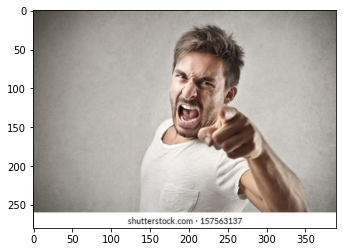

In [25]:
# display the saved image
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [26]:
# pre-trained xml file for landmark of human face
faceCascade = cv2.CascadeClassifier('../input/haarcascade-frontalface/haarcascade_frontalface_default.xml')

In [27]:
# converting rgb images to gray
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
gray.shape

(280, 390)

In [28]:
# for the scale of box defined for face
faces = faceCascade.detectMultiScale(gray, 1.1,4)

In [29]:
# detecting box on face and return gray images of cropped face only
for x, y, w, h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0,0),2)
    faces = faceCascade.detectMultiScale(roi_gray)
    if len(faces) == 0:
        print('face not detected')
    else:
        for(ex, ey, ew, eh) in faces:
            face_roi = roi_gray[ey: ey+eh, ex : ex+ew]

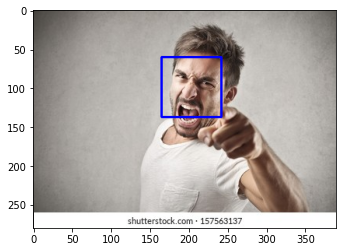

In [30]:
# plotting of detected box on faces
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

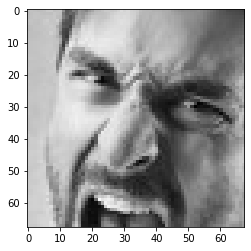

In [31]:
# cropped image for model to train upon
img = cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [32]:
img.shape

(68, 68, 3)

In [33]:
filename= 'te.jpg'
cv2.imwrite(filename, img)

True

In [34]:
image = tf.keras.utils.load_img(filename, color_mode='rgb', target_size=(48,48))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = MobileNetV2_model.predict(input_arr)
predictions

array([[9.6012121e-01, 2.8678167e-04, 3.6072165e-02, 5.6211946e-05,
        4.6549615e-04, 2.7527458e-03, 2.4529174e-04]], dtype=float32)

In [35]:
pd.Series(str(predictions.argmax())).map(class_mapping)[0]

'Angry'